In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 加载数据

In [2]:
from fastai.vision import *

In [3]:
root = Config.data_path()/'aerial-cactus-identification'
root
root.as_posix()

PosixPath('/home/lyc/.fastai/data/aerial-cactus-identification')

'/home/lyc/.fastai/data/aerial-cactus-identification'

- 下载数据

In [4]:
# !kaggle competitions download -c aerial-cactus-identification -p {root.as_posix()}

- 解压缩

In [5]:
# !unzip {root/'train.zip'} -d {root}
# !unzip {root/'test.zip'} -d {root}

- 读入标签

In [6]:
train_df = pd.read_csv(root/"train.csv")
test_df = pd.read_csv(root/"sample_submission.csv")

In [7]:
train_df.head()
test_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


- 测试集构造

In [8]:
test_set = ImageList.from_df(test_df, path=root, cols='id', folder='test')

In [9]:
test_set

ImageList (4000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/lyc/.fastai/data/aerial-cactus-identification

- transforms 定义

In [10]:
tsfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

- databunch 构造

In [11]:
np.random.seed(42)
data = (ImageList.from_df(train_df, path=root, cols='id', folder='train')
       .split_by_rand_pct(0.01)
       .label_from_df()
       .transform(tsfm, size=128)
       .databunch(bs=64)
       .normalize(imagenet_stats)
      )

In [12]:
data

ImageDataBunch;

Train: LabelList (17325 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: /home/lyc/.fastai/data/aerial-cactus-identification;

Valid: LabelList (175 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,1
Path: /home/lyc/.fastai/data/aerial-cactus-identification;

Test: None

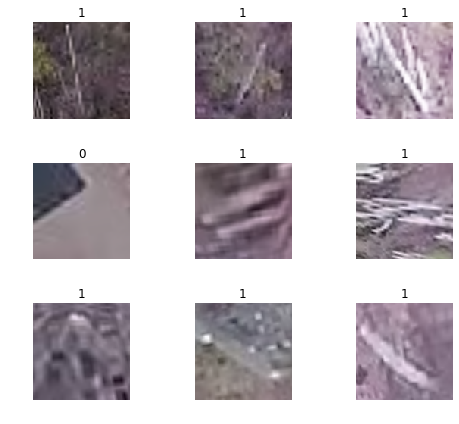

In [13]:
data.show_batch(rows=3, figsize=(7,6))

- 构造模型

## 使用残差网络

In [14]:
# arch = models.resnet34
arch = models.resnet50

In [15]:
learn = cnn_learner(data, arch, metrics=[error_rate, accuracy])

- 寻找最佳学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


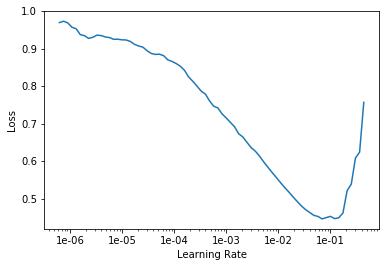

In [16]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.070400,0.045162,0.022857,0.977143,00:40
1,0.040663,0.040580,0.017143,0.982857,00:39
2,0.028821,0.000640,0.000000,1.000000,00:39
3,0.012138,0.000423,0.000000,1.000000,00:40
4,0.010087,0.000475,0.000000,1.000000,00:39


- 第二阶段
- 由于第一阶段已经达到1，所以可以不用进行

In [21]:
learn.unfreeze()

- 再次寻找学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


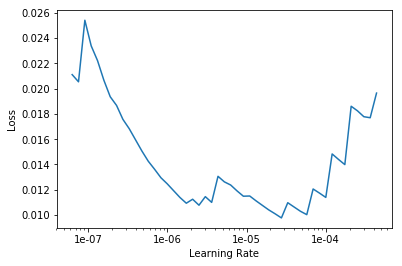

In [23]:
learn.lr_find(start_lr=1e-8, end_lr=1)
learn.recorder.plot()

In [25]:
lr1 = 1e-05
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053133,0.014617,0.005714,0.994286,00:52
1,0.022222,0.004682,0.000000,1.000000,00:52


In [26]:
learn.save('resnet34-stage2')
learn.export()

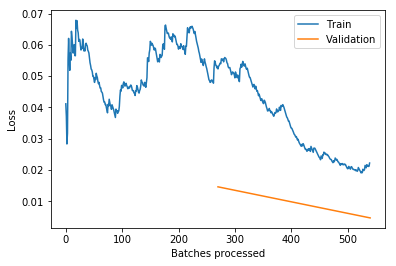

In [27]:
learn.recorder.plot_losses()

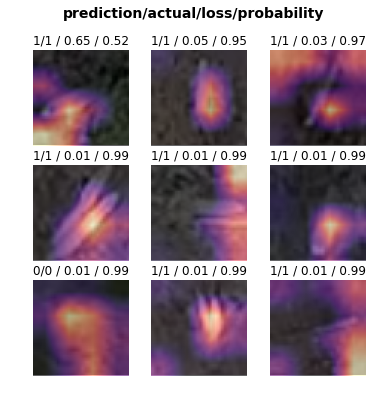

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(6,6))

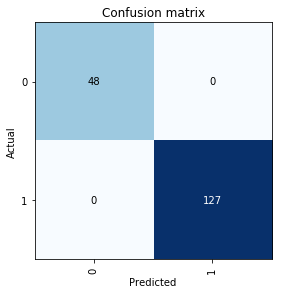

In [29]:
interp.plot_confusion_matrix()

## 预测并提交结果

- 加载最佳模型

In [31]:
learn = load_learner(root, test=test_set)

In [32]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [33]:
preds[:5]

tensor([[4.6159e-05, 9.9995e-01],
        [6.1618e-05, 9.9994e-01],
        [9.9998e-01, 1.7412e-05],
        [9.9996e-01, 4.1444e-05],
        [4.2591e-02, 9.5741e-01]])

In [34]:
test_df.has_cactus = preds.numpy()[:, 0]

In [36]:
test_df.to_csv(root/'submission.csv', index=False)

- 提交结果

In [37]:
# ! kaggle competitions submit aerial-cactus-identification -f {path/'submission.csv'} -m "My submission"